In [4]:
%matplotlib inline

import os
from glob import glob

import yaml
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import ticker
import seaborn
import numpy
import pandas as pd
import networkx
import dinopy
import pybedtools

from sh import bwa, samtools

from phasm.io import gfa
from phasm.assembly_graph import AssemblyGraph
from phasm.bubbles import find_superbubbles

BASE_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))
ALIGNED_CONTIGS_FILE = os.path.join(
    BASE_DIR, "assemblies/{assembly}/05_analysis/aligned_contigs.bam")

with open(os.path.join(BASE_DIR, "config.yml")) as f:
    config = yaml.load(f)
    
#seaborn.set_context('paper')
seaborn.set_style('whitegrid')

## Align contigs to reference

In [9]:
for assembly, asm_config in config['assemblies'].items():
    asm_dir = os.path.join(BASE_DIR, "assemblies", assembly)
    ref_fasta = os.path.join(BASE_DIR, asm_config['reference'])
    bam_file = ALIGNED_CONTIGS_FILE.format(assembly=assembly)
    contigs_fasta = os.path.join(asm_dir, "04_phase", assembly + ".fasta")
    print(contigs_fasta)
    print(bam_file)
    
    os.makedirs(os.path.dirname(bam_file), exist_ok=True)
    
    if not os.path.isfile(ref_fasta + '.bwt'):
        print("Create reference index...")
        # No BWA index available, create one
        bwa.index(ref_fasta)
    
    if not os.path.isfile(bam_file) and os.path.isfile(contigs_fasta):
        print("Creating bam file...")
        samtools.sort(samtools.view(bwa.mem(ref_fasta, contigs_fasta), '-uS', '-'), '-o', bam_file)
        
    if not os.path.isfile(bam_file + '.bai') and os.path.isfile(bam_file):
        samtools.index(bam_file)
    
    print()

/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-10x-error-free/04_phase/ploidy2-10x-error-free.fasta
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-10x-error-free/05_analysis/aligned_contigs.bam

/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-30x-error-free/04_phase/ploidy2-30x-error-free.fasta
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-30x-error-free/05_analysis/aligned_contigs.bam

/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-60x-error-free/04_phase/ploidy2-60x-error-free.fasta
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-60x-error-free/05_analysis/aligned_contigs.bam

/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy3-10x-error-free/04_phase/ploidy3-10x-error-free.fasta
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy3-10x-error-free/05_analysis/aligned_contigs.bam

/run/media/lucas/data/bioinformatics/thesis-data/ass

## Assembly metrics

In [17]:
data = []
for assembly, asm_config in config['assemblies'].items():
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    asm_dir = os.path.join(BASE_DIR, "assemblies", assembly)
    ref_fasta = os.path.join(BASE_DIR, asm_config['reference'])
    bam_file = ALIGNED_CONTIGS_FILE.format(assembly=assembly)
    contigs_fasta = os.path.join(asm_dir, "04_phase", assembly + ".fasta")
    
    if not os.path.isfile(contigs_fasta):
        continue
    
    ref_reader = dinopy.FastaReader(ref_fasta)
    ref_length = sum(e.length for e in ref_reader.entries())
    
    theo_ng50 = ref_length / 2
    ng50 = 0
    
    contig_reader = dinopy.FastaReader(contigs_fasta)
    total_contig_length = 0
    total_haploblock_length = 0
    contig_sequence_len = 0
    contig_lengths = []
    for contig in contig_reader.entries():
        total_contig_length += contig.length
        
        if theo_ng50 <= total_contig_length:
            ng50 = contig.length
            
        name = contig.name.decode('utf-8')
        if "haploblock" in name:
            total_haploblock_length += contig.length
        
        if "contig" in name:
            contig_sequence_len += contig.length
        
        contig_lengths.append(contig.length)
        
    data.append({
        'ploidy': ploidy,
        'coverage': coverage,
        'num_contigs': len(contig_lengths),
        'ng50': ng50,
        'longest_contig': max(contig_lengths),
        'average_contig_len': sum(contig_lengths) / len(contig_lengths),
        'haploblock_fraction': total_haploblock_length / total_contig_length,
        'contig_fraction': contig_sequence_len / total_contig_length
    })
        
df = pd.DataFrame(data)
df 

,average_contig_len,contig_fraction,coverage,haploblock_fraction,longest_contig,ng50,num_contigs,ploidy
0,287949.062500,0.626547,10,0.373453,469213,422603,16,2
1,226984.750000,0.000000,30,1.000000,374533,167175,24,2
2,105027.125000,0.101879,60,0.898121,157358,36878,40,2
3,783624.500000,1.000000,10,0.000000,783633,783633,2,3
4,301153.458333,0.000000,30,1.000000,349561,344055,24,3
5,105272.013889,0.000000,60,1.000000,176918,176856,72,3
6,407773.000000,1.000000,10,0.000000,601790,601691,8,4
7,179530.461538,0.000000,30,1.000000,304847,304847,52,4
8,783439.000000,1.000000,10,0.000000,783509,0,2,6
9,474165.875000,0.000000,30,1.000000,634392,634374,24,6


## Percentage of reference genome covered

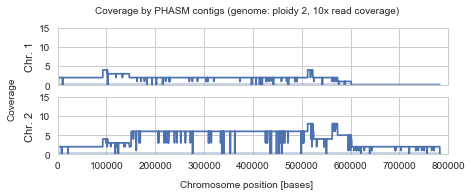

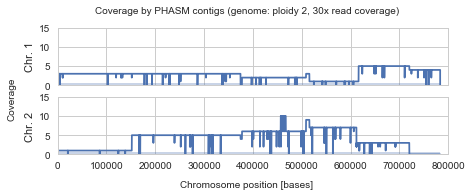

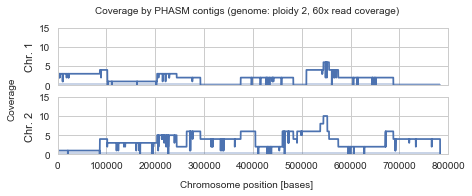

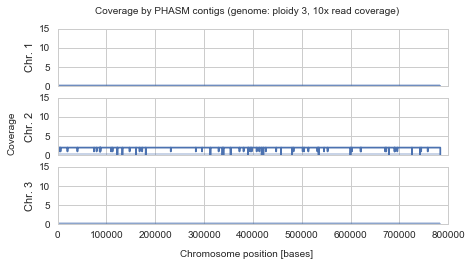

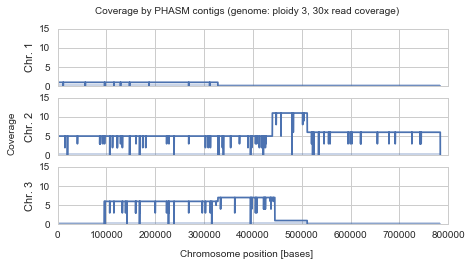

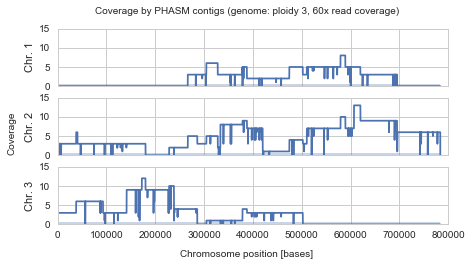

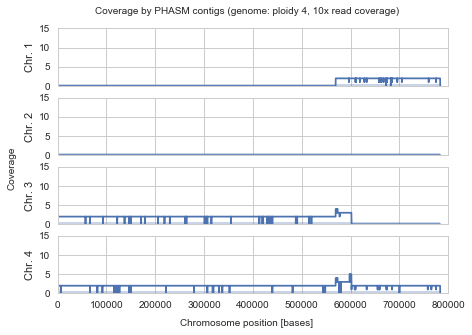

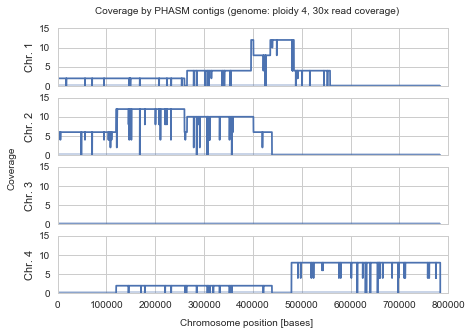

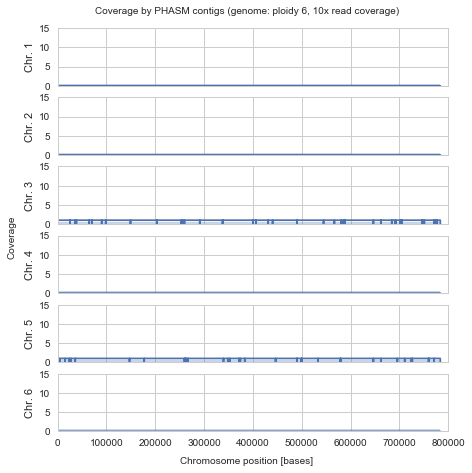

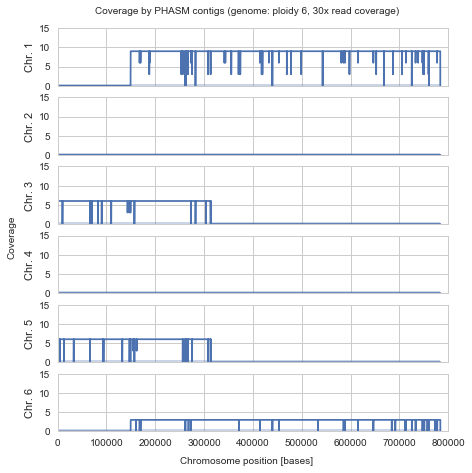

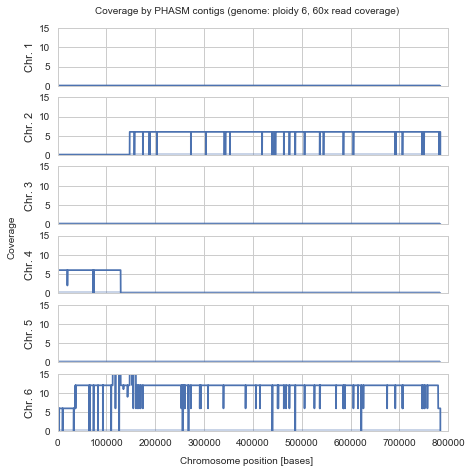

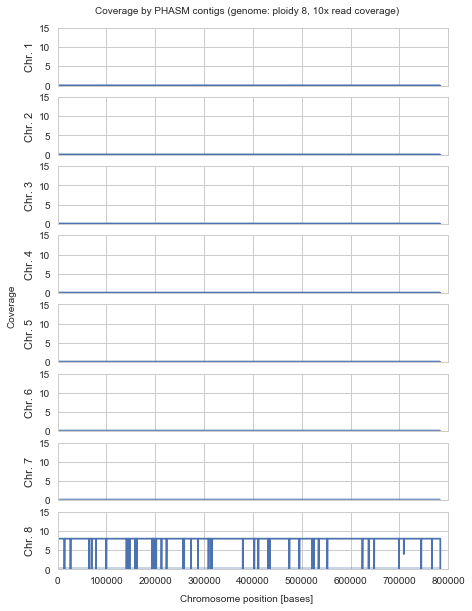

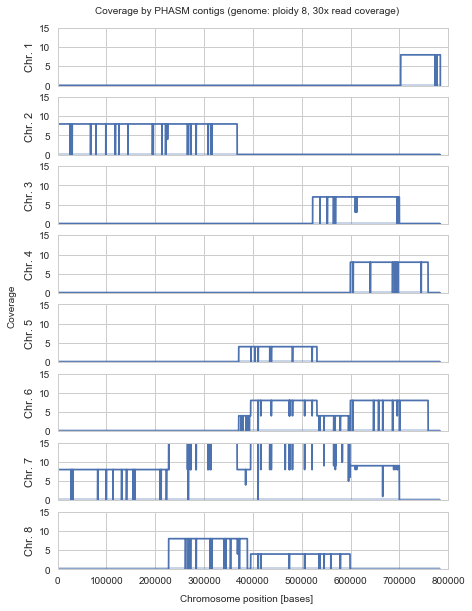

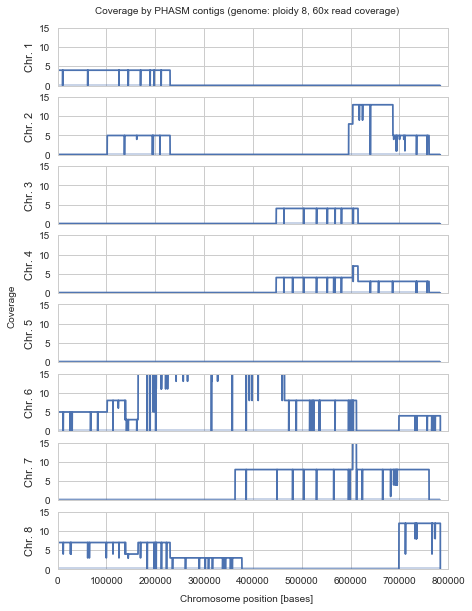

In [44]:
def contig_filter(f, name):
    return f[0] == name

for assembly, asm_config in config['assemblies'].items():
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    asm_dir = os.path.join(BASE_DIR, "assemblies", assembly)
    ref_fasta = os.path.join(BASE_DIR, asm_config['reference'])
    bam_file = ALIGNED_CONTIGS_FILE.format(assembly=assembly)
    contigs_fasta = os.path.join(asm_dir, "04_phase", assembly + ".fasta")
    
    if not os.path.isfile(contigs_fasta):
        continue
    
    top_margin = 0.4  # inches
    bottom_margin = 0.6  # inches
    total_margin = top_margin + bottom_margin
    axis_height = 0.8
    hspace = 0.2
    all_axis_height = (ploidy*axis_height) + ((ploidy-1) * (axis_height*hspace))
    
    margin_fraction = total_margin / (all_axis_height + total_margin)
    top_margin_frac = (top_margin * margin_fraction) / total_margin
    bottom_margin_frac = (bottom_margin * margin_fraction) / total_margin
    
    fig_height = all_axis_height + total_margin
    fig, ax = plt.subplots(ploidy, sharex=True, figsize=(7, fig_height))
    bt = pybedtools.BedTool()
    fr = dinopy.FastaReader(ref_fasta)
    for i, homolog in enumerate(fr.entries()):
        name = homolog.name.decode('utf-8')
        chr_id = name.split()[0]
        
        cov = bt.genome_coverage(ibam=bam_file, bga=True, stream=True).filter(
            contig_filter, chr_id)
        
        coverage_data = numpy.zeros((homolog.length,))
        for region in cov:
            start = int(region[1])
            end = int(region[2])
            reg_coverage = int(region[3])
            
            coverage_data[start:end] = reg_coverage
        
        ax[i].plot(coverage_data)
        ax[i].set_xlim((0, 800000))
        ax[i].set_ylim((0, 15))
        ax[i].set_ylabel("Chr. {}".format(i+1))
        ax[i].yaxis.set_major_locator(ticker.MultipleLocator(5))
        
        ax[i].add_patch(
            patches.Rectangle((0, 0), homolog.length, 0.5, alpha=0.3)
        )
        
    fig.subplots_adjust(bottom=bottom_margin_frac,
                        top=(1-top_margin_frac), hspace=hspace)
    fig.text(0.5, (1-top_margin_frac)+(top_margin_frac/2), "Coverage by PHASM contigs (genome: ploidy {}, {}x read coverage)".format(ploidy, coverage),
             ha="center")
    fig.text(0.5, bottom_margin_frac-((bottom_margin_frac/2) + (bottom_margin_frac/4)), "Chromosome position [bases]",
             ha="center")
    fig.text(0.025, 0.5, "Coverage", rotation="vertical", va="center")
    fig.savefig(os.path.join(BASE_DIR, 'figures', assembly + '-cov.png'), dpi=256, transparent=True)